In [1]:
import scCube
from scCube import scCube
from scCube.visualization import *
from scCube.utils import *
from matplotlib.pyplot import rc_context
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

/slurm/home/yrd/fanlab/qianjingyang/.conda/envs/sccube/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = scCube()

In [3]:
# bregma: 0.06
sc_adata1 = sc.read('demo_data/MERFISH_0.06_adata.h5ad')
sc_adata1.layers["data"] = sc_adata1.X

# bregma: -0.29
sc_adata2 = sc.read('demo_data/MERFISH_n0.29_adata.h5ad')
sc_adata2.layers["data"] = sc_adata2.X

In [5]:
generate_sc_meta, generate_sc_data = model.train_vae_and_generate_cell(
    sc_adata=sc_adata1,
    celltype_key='Cell_type',
    cell_key='Cell',
    target_num=dict(sc_adata2.obs.Cell_type.value_counts()),
    batch_size=512,
    epoch_num=10000,
    lr=0.0001,
    hidden_size=128,
    save_model=False,
    used_device='cuda:1')

generating by the targeted proportion of cell types...
begin vae training...


Train Epoch: 9999: 100%|██████████| 10000/10000 [09:55<00:00, 16.78it/s, loss=5.6568, min_loss=5.6463] 


vae training done!


Generate Epoch: 1: 100%|██████████| 5517/5517 [00:00<00:00, 100567.49it/s]

generated done!
data have been prepared!


In [6]:
generate_sc_data, generate_sc_meta = model.generate_pattern_reference(
        sc_adata=sc_adata2,
        generate_sc_data=generate_sc_data,
        generate_sc_meta=generate_sc_meta,
        celltype_key='Cell_type',
        spatial_key=['x', 'y'],
        cost_metric='sqeuclidean'
)

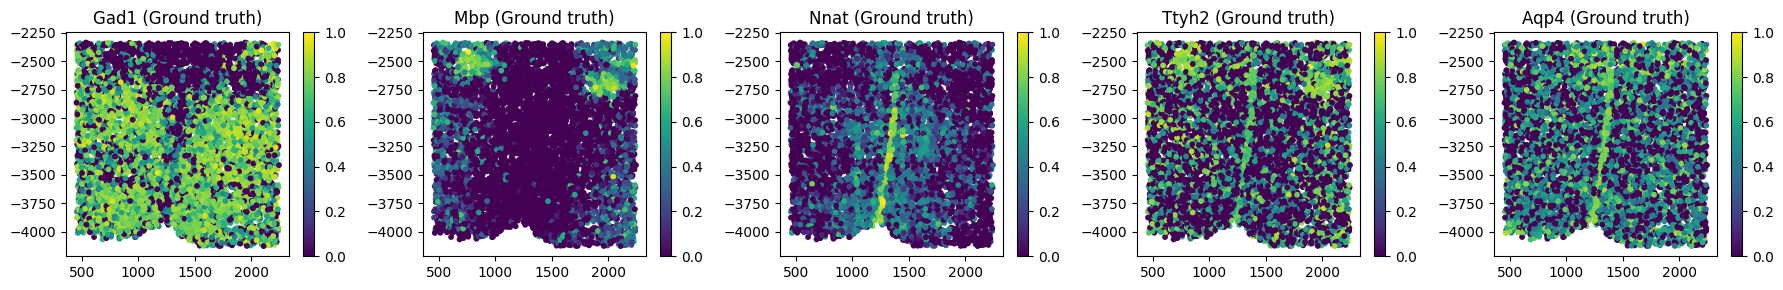

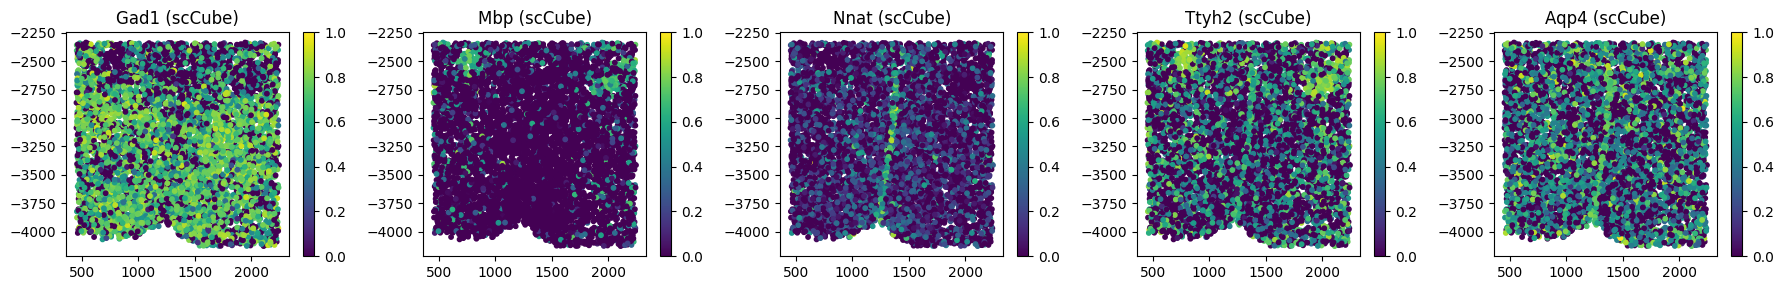

In [9]:
genes = ['Gad1', 'Mbp', 'Nnat', 'Ttyh2', 'Aqp4']
sc_data_norm = sc_adata2.to_df(layer = 'data')

# real data
obj = sc_adata2.obs
obj.index = list(obj['Cell'])
gene_exp = sc_data_norm[genes]
x = obj['x']
y = obj['y']
fig, axes = plt.subplots(1,5,figsize=(18, 3))

for i in range(len(genes)):
    gene_exp_tmp = gene_exp[genes[i]]
    gene_exp_tmp = (gene_exp_tmp - gene_exp_tmp.min()) / (gene_exp_tmp.max() - gene_exp_tmp.min())
    g = axes[i].scatter(x, y, s=10, cmap='viridis', c=gene_exp_tmp)
    axes[i].set_title(genes[i] + ' (Ground truth)')
    fig.colorbar(g, ax=axes[i])

plt.tight_layout()

# scCube
obj = generate_sc_meta
obj.index = list(obj['Cell'])
gene_exp = generate_sc_data.T[genes]
x = obj['x']
y = obj['y']
fig, axes = plt.subplots(1,5, figsize=(18, 3))

for i in range(len(genes)):
    gene_exp_tmp = gene_exp[genes[i]]
    gene_exp_tmp = (gene_exp_tmp - gene_exp_tmp.min()) / (gene_exp_tmp.max() - gene_exp_tmp.min())
    g = axes[i].scatter(x, y, s=10, cmap='viridis', c=gene_exp_tmp)
    axes[i].set_title(genes[i] + ' (scCube)')
    fig.colorbar(g, ax=axes[i])

plt.tight_layout()
plt.show()